# LDA similarity

https://www.kaggle.com/ktattan/lda-and-document-similarity

### imports

In [1]:
import PyPDF2
import textract
import os

import numpy as np
import pandas as pd
import seaborn as sns
import re
import time
from scipy.stats import entropy
import matplotlib.pyplot as plt

from gensim.models import word2vec
import gensim.downloader as api

import gensim
from gensim.models import LdaModel
from gensim import models, corpora, similarities
from sklearn.metrics.pairwise import cosine_similarity
from sklearn import metrics, datasets, neighbors, decomposition

import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk import FreqDist

### load data

In [2]:
df = pd.read_csv('../data/raw/supreme_court_opinions_2013_tokenized.csv', converters={
    'nltk_tokenized': eval, 
    "nltk_sentences": eval,
    'nltk_sentences_tok': eval
    }).drop('Unnamed: 0', axis = 1)

In [3]:
STOP_WORDS = nltk.corpus.stopwords.words('english')

In [4]:
# tokenizer function same as in preprocess notebook
def tokenize_text(text):
    
    text_tokenized = nltk.word_tokenize(text)
    text_tokenized = [x.lower() for x in text_tokenized]
    wordlist = []
    for word in text_tokenized: 
        
        if ((word not in STOP_WORDS) and (len(word)>2)):            
            wordlist.append(word)
        # if not (word.isalnum()):            
        # text_tokenized.remove(word)
            
    return(wordlist)

In [ ]:
df['nltk_tokenized'] = df['raw text'].apply(lambda x: tokenize_text(x))
df['nltk_sentences'] = df['raw text'].apply(lambda x: nltk.sent_tokenize(x))
df['nltk_sentences_tok'] = df['nltk_sentences'].apply(lambda x: [tokenize_text(i) for i in x])

In [6]:
df

,raw text,nltk_sentences,nltk_tokenized,nltk_sentences_tok
0,\n \n \n \n \n ...,[ \n \n \n \n \n...,"[slip, opinion, october, term, 2013, syllabus,...","[[slip, opinion, october, term, 2013, syllabus..."
1,\n \n 1 (Slip Op...,[ \n \n 1 (Slip O...,"[slip, opinion, october, term, 2013, syllabus,...","[[slip, opinion, october, term, 2013, syllabus..."
2,\n \n ...,[ \n \n ...,"[slip, opinion, october, term, 2013, syllabus,...","[[slip, opinion, october, term, 2013, syllabus..."
3,\n \n \n 1 (Sl...,[ \n \n \n 1 (S...,"[slip, opinion, october, term, 2013, syllabus,...","[[slip, opinion, october, term, 2013, syllabus..."
4,\n \n \...,[ \n \n ...,"[slip, opinion, october, term, 2013, syllabus,...","[[slip, opinion, october, term, 2013, syllabus..."
...,...,...,...,...
67,\n \n \n \n 1...,[ \n \n \n \n ...,"[slip, opinion, october, term, 2013, syllabus,...","[[slip, opinion, october, term, 2013, syllabus..."
68,\n \n 1 Cite as: 572 ...,[ \n \n 1 Cite as: 572...,"[cite, 572, ____, 2014, per, curiam, supreme, ...","[[cite, 572, ____, 2014, per, curiam, supreme,..."
69,1 Cite as: 572 U. S. ____ (20...,[ 1 Cite as: 572 U. S. ____ (2...,"[cite, 572, ____, 2014, per, curiam, supreme, ...","[[cite, 572, ____, 2014, per, curiam, supreme,..."
70,\n 1 Cite as: 571 U. S. ____ ...,[ \n 1 Cite as: 571 U. S. ____...,"[cite, 571, ____, 2014, per, curiam, supreme, ...","[[cite, 571, ____, 2014, per, curiam, supreme,..."


In [7]:
sentences = df['nltk_sentences'].explode()
sentences_tok = df['nltk_sentences_tok'].explode()
id = range(len(sentences))
sent = pd.DataFrame({'raw' : sentences, 'tokenized' : sentences_tok, 'id' : id}).set_index('id')

In [8]:
sent

,raw,tokenized
id,,
0,\n \n \n \n \n ...,"[slip, opinion, october, term, 2013, syllabus,..."
1,The syllabus constitutes no part of the opinio...,"[syllabus, constitutes, part, opinion, court, ..."
2,See \nUnited States\n v. Detroit Timber & Lumb...,"[see, united, states, detroit, timber, lumber,..."
3,SUPREME COURT OF THE UNITED STATES \nSyllabus ...,"[supreme, court, united, states, syllabus, har..."
4,"v. QUINN, GOVERNOR OF ILLINOIS, \nET AL\n.","[quinn, governor, illinois]"
...,...,...
33736,13Œ9085.,[13œ9085]
33737,"Decided July 1, 2014\n PER CURIAM\n.","[decided, july, 2014, per, curiam]"
33738,The motion for leave to proceed \nin forma pau...,"[motion, leave, proceed, forma, pauperis, peti..."


### word frequency

In [196]:
# first get a list of all words
all_words = [word for text in list(sent['tokenized']) for word in text]
# use nltk fdist to get a frequency distribution of all words
fdist = FreqDist(all_words)
len(fdist) # number of unique words

14463

In [199]:
top_words = fdist.most_common(9000)
#top_words[-20:]

In [200]:
top_words,_ = zip(*fdist.most_common(9000))
top_words = set(top_words)
def keep_top_words(text):
    return [word for word in text if word in top_words]
sent['tokenized_k'] = sent['tokenized'].apply(keep_top_words)

In [201]:
# document length

sent['doc_len'] = sent['tokenized'].apply(lambda x: len(x))
doc_lengths = list(sent['doc_len'])
sent.drop(labels='doc_len', axis=1, inplace=True)

In [237]:
# only keep articles with more than 35 tokens, otherwise too short
sent = sent[sent['tokenized_k'].map(len) >= 30]
# make sure all tokenized items are lists
sent = sent[sent['tokenized_k'].map(type) == list]
sent.reset_index(drop=True,inplace=True)
print("After cleaning and excluding short aticles, the dataframe now has:", len(sent), "articles")

After cleaning and excluding short aticles, the dataframe now has: 1201 articles


### Train lda

In [203]:
def train_lda(data):
    """
    This function trains the lda model
    We setup parameters like number of topics, the chunksize to use in Hoffman method
    We also do 2 passes of the data since this is a small dataset, so we want the distributions to stabilize
    """
    num_topics = 100
    chunksize = 300
    dictionary = corpora.Dictionary(data['tokenized_k'])
    corpus = [dictionary.doc2bow(doc) for doc in data['tokenized_k']]
    t1 = time.time()
    # low alpha means each document is only represented by a small number of topics, and vice versa
    # low eta means each topic is only represented by a small number of words, and vice versa
    lda = LdaModel(corpus=corpus, num_topics=num_topics, id2word=dictionary,
                   alpha=1e-2, eta=0.5e-2, chunksize=chunksize, minimum_probability=0.0, passes=2)
    t2 = time.time()
    print("Time to train LDA model on ", len(sent), "articles: ", (t2-t1)/60, "min")
    return dictionary,corpus,lda

In [241]:
dictionary,corpus,lda = train_lda(sent)

Time to train LDA model on  1201 articles:  0.06546427408854166 min


### See what's in the box (model)

739
[(36, 1), (54, 1), (71, 2), (363, 1), (383, 1), (552, 1), (1397, 2), (1426, 1), (1527, 1), (1585, 1), (1891, 1), (2471, 2), (2691, 1), (3160, 3), (3547, 1), (3759, 1), (3764, 1), (3767, 1), (3777, 1), (4748, 1), (5014, 1), (5165, 1), (7099, 1), (7298, 1), (7865, 1), (8019, 2), (8072, 2), (8073, 1), (8074, 2)]
['šššššš', 'e.g.', 'prayer', 'practice', 'city', 'letter', 'freedom', 'religion', 'foundation', 'city', 'saginaw', 'city', 'council', 'jan.', '2014', 'online', 'http', 'saginaw', 'materials', 'visited', 'may', '2014', 'available', 'clerk', 'court™s', 'case', 'file', 'prayer', 'practice', 'cobb', 'county', 'georgia', 'described', 'cobb', 'county', '410', 'supp']


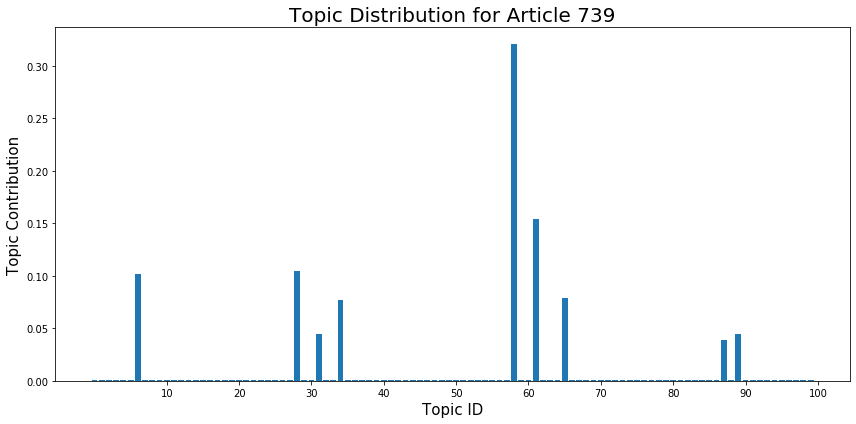

In [242]:
# show_topics method shows the the top num_words contributing to num_topics number of random topics
lda.show_topics(num_topics=10, num_words=4)

# select and article at random from train_df
random_article_index = np.random.randint(len(sent))
bow = dictionary.doc2bow(sent.iloc[random_article_index,2])
print(random_article_index)
print(bow)

print(sent.iloc[random_article_index,2])

# get the topic contributions for the document chosen at random above
doc_distribution = np.array([tup[1] for tup in lda.get_document_topics(bow=bow)])
len(doc_distribution)

# bar plot of topic distribution for this document
fig, ax = plt.subplots(figsize=(12,6));
# the histogram of the data
patches = ax.bar(np.arange(len(doc_distribution)), doc_distribution)
ax.set_xlabel('Topic ID', fontsize=15)
ax.set_ylabel('Topic Contribution', fontsize=15)
ax.set_title("Topic Distribution for Article " + str(random_article_index), fontsize=20)
ax.set_xticks(np.linspace(10,100,10))
fig.tight_layout()
plt.show()

### and here it comes finally: similarity

In [264]:
# get all topic distributions into a matrix (one row is one sentence/text, one column is one topic)
# we need to use nested list comprehension here
# this may take 1-2 minutes...
doc_topic_dist = np.array([[tup[1] for tup in lst] for lst in lda[corpus]])
doc_topic_dist.shape

(1201, 100)

In [265]:
def jensen_shannon(query, matrix):
    """
    This function implements a Jensen-Shannon similarity
    between the input query (an LDA topic distribution for a document)
    and the entire corpus of topic distributions.
    It returns an array of length M where M is the number of documents in the corpus
    """
    # lets keep with the p,q notation above
    #p = query[None,:].T # take transpose
    p = (new_doc_distribution * np.ones((len(matrix),len(new_doc_distribution)))).T
    q = matrix.T # transpose matrix
    m = 0.5*(p + q)
    ent1 = entropy(p,m)
    ent2 = entropy(q,m)
    return np.sqrt(0.5*( ent1 + ent2))

In [266]:
def get_most_similar_documents(query,matrix,k=10):
    """
    This function implements the Jensen-Shannon distance above
    and retruns the top k indices of the smallest jensen shannon distances
    """
    sims = jensen_shannon(query,matrix) # list of jensen shannon distances
    return sims.argsort()[:k] # the top k positional index of the smallest Jensen Shannon distances

In [286]:
# select and article at random from test_df
random_article_index = np.random.randint(len(sent))

new_bow = dictionary.doc2bow(sent.iloc[random_article_index,2])
new_doc_distribution = np.array([tup[1] for tup in lda.get_document_topics(bow=new_bow)])

print(random_article_index)
print(sent.iloc[random_article_index,2])

156
['linguistic', 'matter', 'one', 'easily', 'read', 'implicit', 'exception', 'small-scale', 'green-house', 'gas', 'emissions', 'phrase', 'ﬁany', 'sourceﬂ', 'phrase', 'ﬁany', 'air', 'pollutant.ﬂ', 'given', 'purposes', 'psd', 'program', 'act', 'whole', 'well', 'specific', 'roles', 'different', 'parts', 'statutory', 'defini', 'tion', 'finding', 'flexibility', 'ﬁany', 'sourceﬂ', 'far', 'sensible', 'court™s', 'route', 'finding', 'ﬁany', 'air', 'pollutant.ﬂ', 'implicit', 'exception', 'propose', 'reads', 'almost', 'word', 'word', 'court™s', 'except', 'location', 'exception', 'shifted']


In [287]:
# this is surprisingly fast
most_sim_ids = get_most_similar_documents(new_doc_distribution,doc_topic_dist)

In [288]:
most_similar_df = sent[sent.index.isin(most_sim_ids)]
for i in most_similar_df['raw']:
    print (i)
    print()
    print()

9 * * * 
To sum up: We hold that 
EPA exceeded its statutory 
authority when it interpreted 
the Clean Air Act to require
PSD and Title V permitting for stationary sources based 

on their greenhouse-gas emission
s.  Specifically, the Agency 
may not treat greenhouse gases as a pollutant for pur- 

poses of defining a ﬁmajor emitting facilityﬂ (or a ﬁmodifi
-
cationﬂ thereof) in the PSD cont
ext or a ﬁmajor sourceﬂ in
the Title V context.


Court reads the statute as defining ﬁmajor emitting facilityﬂ 
to mean ﬁstationary sources that have the potential to 
emit two hundred fifty tons per year or more of any air 

pollutant except for those air pollutants, such as carbon 
dioxide, with respect to which regulation at that threshold 

would be impractical or absurd or would sweep in smaller 

sources that Congress did not mean to cover
.ﬂ See 
ante, at 15Œ16 (ﬁ[T]here is no insuperable textual barrier to EPA™s

interpreting ‚any air pollutant™ in the permitting triggers 
of PSD and Title